In [15]:
pip install python-resize-image

Note: you may need to restart the kernel to use updated packages.


In [16]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, QuantumRegister
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit import execute, Aer, BasicAer
import numpy as np
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mutual_info_score, r2_score
from resizeimage import resizeimage
from PIL import Image


In [17]:
def margolus(circ, t, c0, c1):
        circ.ry(np.pi/4,t)
        circ.cx(c0, t)
        circ.ry(np.pi/4,t)
        circ.cx(c1, t)
        circ.ry(-np.pi/4,t)
        circ.cx(c0, t)
        circ.ry(-np.pi/4,t)

In [18]:
def rccx(circ, t, c0, c1):
        circ.h(t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.cx(c1, t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.h(t)


In [19]:
def rcccx(circ, t, c0, c1, c2):
        circ.h(t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.h(t)
        circ.cx(c1, t)
        circ.t(t)
        circ.cx(c2, t)
        circ.tdg(t)
        circ.cx(c1, t)
        circ.t(t)
        circ.cx(c2, t)
        circ.tdg(t)
        circ.h(t)
        circ.t(t)
        circ.cx(c0, t)
        circ.tdg(t)
        circ.h(t)


In [20]:
def ccry(circ, angle, t, c0, c1):
        circ.cu3(angle/2, 0, 0, c1, t)
        circ.cx(c1, c0)
        circ.cu3(-angle/2, 0, 0, c0, t)
        circ.cx(c1, c0)
        circ.cu3(angle/2, 0, 0, c0, t)

In [21]:
def mary(circ, angle, t, c0, c1):
        circ.ry(angle/4,t)
        circ.cx(c0, t)
        circ.ry(-angle/4,t)
        circ.cx(c1, t)
        circ.ry(angle/4,t)
        circ.cx(c0, t)
        circ.ry(-angle/4,t)
        circ.cx(c1, t)


In [22]:
def cccry(circ, angle, t, a, c0, c1, c2):
        margolus(circ, a, c1, c2)
        mary(circ, angle, t, a, c0)
        margolus(circ, a, c1, c2)


In [23]:
def mary_4(circ, angle, t, c0, c1, c2):
        circ.h(t)
        circ.t(t)
        circ.cx(c0,t)
        circ.tdg(t)
        circ.h(t)
        circ.cx(c1,t)
        circ.rz(angle/4,t)
        circ.cx(c2,t)
        circ.rz(-angle/4,t)
        circ.cx(c1,t)
        circ.rz(angle/4,t)
        circ.cx(c2,t)
        circ.rz(-angle/4,t)
        circ.h(t)
        circ.t(t)
        circ.cx(c0,t)
        circ.tdg(t)
        circ.h(t)

In [24]:
def mary_8(circ, angle, t, c0, c1, c2, c3, c4, c5, c6):
        circ.h(t)
        circ.t(t)
        rccx(circ, t, c0, c1)
        circ.tdg(t)
        circ.h(t)
        rccx(circ, t, c2, c3)
        circ.rz(angle/4,t)
        rcccx(circ, t, c4, c5, c6)
        circ.rz(-angle/4,t)
        rccx(circ, t, c2, c3)
        circ.rz(angle/4,t)
        rcccx(circ, t, c4, c5, c6)
        circ.rz(-angle/4,t)
        circ.h(t)
        circ.t(t)
        rccx(circ, t, c0, c1)
        circ.tdg(t)
        circ.h(t)
        

In [25]:
def c10ry(circ, angle, bin, target, anc, controls):
# c10mary(qc, 2 * x_train[img_num][i], format(i, '010b'), 0, 1, [i for i in range(2,12)])
        print(bin)
        clist = []

        for i in bin:
                clist.append(int(i))

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])

        margolus(circ, anc, controls[0], controls[1])
        circ.x(controls[0])
        circ.x(controls[1])
        margolus(circ, controls[1], controls[2], controls[3])
        circ.x(controls[2])
        circ.x(controls[3])
        margolus(circ, controls[3], controls[4], controls[5])
        circ.x(controls[4])
        circ.x(controls[5])
        
        margolus(circ, controls[5], controls[8], controls[9])
        margolus(circ, controls[4], controls[6], controls[7])
        margolus(circ, controls[2], controls[4], controls[5])
        margolus(circ, controls[0], controls[2], controls[3])

        mary_4(circ, angle, target, anc, controls[0], controls[1])

        margolus(circ, controls[0], controls[2], controls[3])
        margolus(circ, controls[2], controls[4], controls[5])
        margolus(circ, controls[4], controls[6], controls[7])
        margolus(circ, controls[5], controls[8], controls[9])
        
        circ.x(controls[5])
        circ.x(controls[4])
        margolus(circ, controls[3], controls[4], controls[5])
        circ.x(controls[3])
        circ.x(controls[2])
        margolus(circ, controls[1], controls[2], controls[3])
        circ.x(controls[1])
        circ.x(controls[0])
        margolus(circ, anc, controls[0], controls[1])

        for i in range(len(clist)):
            if clist[i] == 0:
                circ.x(controls[-i-1])
        


In [26]:
    def c10mary(circ, angle, bin, target, anc, controls):

        # c10mary(qc, 2 * x_train[img_num][i], format(i, '010b'), 0, 1, [i for i in range(2,12)])
        clist = []

        for i in bin:
                clist.append(int(i))
        # print("angle", angle)
        # print("clist - bin",clist)

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])

        rccx(circ, anc, controls[4], controls[5])
        # circuit_drawer(circ,output='mpl', filename='my_circuit_rccx.png')
        circ.x(controls[4])
        circ.x(controls[5])
        rccx(circ, controls[4], controls[6], controls[7])
        rccx(circ, controls[5], controls[8], controls[9])


        mary_8(circ, angle, target, anc, controls[0], controls[1], controls[2], controls[3], controls[4], controls[5])

        rccx(circ, controls[5], controls[8], controls[9])
        rccx(circ, controls[4], controls[6], controls[7])
        circ.x(controls[5])
        circ.x(controls[4])
        rccx(circ, anc, controls[4], controls[5])

        for i in range(len(clist)):
                if clist[i] == 0:
                        circ.x(controls[-i-1])
        # for i  in range(len(clist)):
        #         circ.x(controls[i])


In [27]:
def image_normalization(image):
    image = resizeimage.resize_cover(image, [32, 32])
    w, h = 32, 32
    image = np.array([[image.getpixel((x,y))[0] for x in range(w)] for y in range(h)])

    # 2-dimentional data convert to 1-dimentional array
    image = image.flatten()
    # change type
    image = image.astype('float64')
    # Normalization(0~pi/2)
    image /= 255.0
    generated_image = np.arcsin(image)

    return generated_image


{'100110111101': 1018, '110101010100': 1023, '001100000000': 982, '111011110100': 953, '100111110000': 1024, '110100100101': 1023, '010001010100': 972, '011110101100': 959, '010010011000': 956, '110111100100': 972, '010100100000': 973, '101100010100': 1051, '011101101000': 970, '010011001000': 983, '011000001100': 944, '110101110100': 992, '000111010000': 943, '000010100100': 978, '011011100100': 971, '010011000000': 969, '111101010100': 885, '110101000101': 935, '100110111001': 942, '001100111000': 954, '110111110100': 974, '011010101100': 983, '001011011000': 1009, '110100000100': 1004, '011001011001': 847, '100000100000': 986, '010110010100': 988, '010100001100': 942, '101111000001': 1021, '111110000000': 971, '011011010100': 441, '011111010101': 1011, '011111000101': 685, '101111111100': 1035, '110011011000': 1010, '001110000100': 974, '110110111001': 991, '010100111100': 998, '111001101000': 981, '111100111001': 1013, '101010100000': 996, '111110000100': 988, '101111000101': 998, 

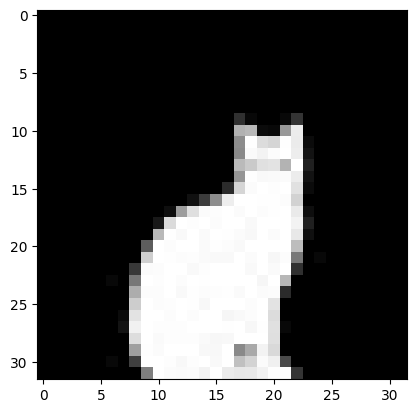

In [28]:
if __name__ == '__main__':
        # (x_train, y_train), (x_test, y_test) = mnist.load_data()
        # img_num = 1

        # #show original image
        # plt.imshow(x_train[img_num], cmap='gray')
        # #plt.savefig('mnistimg'+str(img_num)+'.png')
        # plt.show()

        # # 2-dimentional data convert to 1-dimentional array
        # x_train = x_train.reshape(60000, 784)
        # # change type
        # x_train = x_train.astype('float64')
        # # Normalization(0~pi/2)
        # x_train /= 255.0
        # x_train = np.arcsin(x_train)
        x_train=image_normalization(Image.open("cat.png").convert('LA'))

        backends = Aer.backends()
        
        #print("Aer backends:",backends)

        qubit = 12
        qc = QuantumCircuit(qubit,qubit)


        # apply hadamard gates
        qc.h(range(2,qubit))
        # image1 = image_normalization(image1)
        

        # apply c10Ry gates (representing color data)
        for i in range(len(x_train)):
                if x_train[i] != 0:
                        c10mary(qc, 2 * x_train[i], format(i, '010b'), 0, 1, [i for i in range(2,12)])

        # qc.x(range(2,qubit))
        qc.measure(range(qubit),range(qubit))

        backend_sim = Aer.get_backend('qasm_simulator')
        #print(qc.depth())
        numOfShots = 1000000
        result = execute(qc, backend_sim, shots=numOfShots).result()
        #circuit_drawer(qc).show()
        #plot_histogram(result.get_counts(qc))

        print(result.get_counts(qc))

        # generated image
        genimg = np.array([])

        #### decode
        for i in range(len(x_train)):
                try:
                        genimg = np.append(genimg,[np.sqrt(result.get_counts(qc)[format(i, '010b')+'01']/numOfShots)])
                except KeyError:
                        genimg = np.append(genimg,[0.0])

        # inverse nomalization
        genimg *= 32.0 * 255.0
        x_train = np.sin(x_train)
        x_train *= 255.0

        # convert type
        genimg = genimg.astype('int')

        # back to 2-dimentional data
        genimg = genimg.reshape((32,32))

        plt.imshow(genimg, cmap='gray', vmin=0, vmax=255)
        # plt.savefig('gen_'+str(img_num)+'.png')
        plt.show()

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from resizeimage import resizeimage
from PIL import Image, ImageOps


In [30]:
def get_MNIST_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    return x_train

In [31]:
def get_Cat_320_image():
    return Image.open("cat_320.png").convert('LA')

In [32]:
def get_Cat_image():
    return Image.open("cat.png").convert('LA')


In [33]:
def large_image_normalization(images,w,h):
    image=np.array([])
   
    for y in range(h-32,h):
         for x in range(w-32,w):
            image=np.append(image,images.getpixel((x,y))[0])
    genimg = image.reshape((32,32))
    image = image.flatten()
    # change type
    image = image.astype('float64')
    # Normalization(0~pi/2)
    image /= 255.0
    generated_image=image
    # generated_image = np.arcsin(image)
    print(generated_image)
    image=images
    return generated_image

In [34]:
def image_normalization(image,size,show):
    image = resizeimage.resize_cover(image, [size, size])
    w, h = size, size
    image = np.array([[image.getpixel((x,y))[0] for x in range(w)] for y in range(h)])
    
    # display the image
    if show:
        genimg = image.reshape((size,size))
        plt.imshow(genimg, cmap='gray', vmin=0, vmax=255)
        plt.show()
    
    image = image.flatten()
    image = image.astype('float64')
    image /= 255.0
    generated_image = np.arcsin(image)
    # print(generated_image)
    return generated_image

In [35]:
def generate_image(size):
    w, h = size, size
    data = np.zeros((h, w, 3), dtype=np.uint8)
    w_bound=int(w/2)
    h_bound=int(h/2)
    data[0:w_bound, 0:h_bound] = [255, 0, 0] # red patch in upper left
    data[0:w_bound, h_bound+1:h] = [0, 255, 0] # red patch in upper left
    data[w_bound+1:w, 0:h_bound] = [0, 0, 255] # red patch in upper left
    data[w_bound+1:w, h_bound+1:h] = [128, 128, 128] # red patch in upper left

    imgq = Image.fromarray(data, 'RGB')
    imgq.save('my.png')
    return imgq.convert('LA')

In [36]:
def get_image_pixel_value(image,size):
    img_arr= np.array([[image.getpixel((x,y))[0] for x in range(size)] for y in range(size)])
    img_arr = img_arr.flatten()
    return img_arr


In [37]:
def get_count_of_pixel(arr1,arr2):
    same=0
    notsame=0
    for i in range(len(arr1)):
        if arr1[i]==arr2[i]:
            same+=1
        else:
            notsame+=1
    return (same,notsame)

In [38]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute
from qiskit.circuit.library import QFT
from math import pi
from qiskit import Aer

In [39]:
def quantum_adder(circuit, epsilon):
    qubits = circuit.qubits
    n_qubits = circuit.n_qubits
    QFT.construct_circuit(circuit, qubits)
    for i in range(n_qubits):
        circuit.u1(float(2 * pi * epsilon)/2**(i + 1), qubits[n_qubits - i - 1])
    QFT.construct_circuit(circuit, qubits, inverse=True)

In [40]:
def quantum_rotate_image(circuit):        #gives you the quantum state where you have to measure the ancilla and obtain 0
    for i in circuit.qubits:
        circuit.x(i)


In [41]:
def quantum_edge_detection(circuit):        #gives you the quantum state where you have to measure the ancilla and obtain 0
    qubits = circuit.qubits
    ancilla = qubits[0]
    circuit.h(ancilla)
    quantum_adder(circuit, -1)
    circuit.h(ancilla)
    circuit.x(ancilla)



In [42]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, QuantumRegister
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit import execute, Aer, BasicAer
from qiskit_aer.noise import NoiseModel
import numpy as np
import matplotlib.pyplot as plt
from resizeimage import resizeimage
from PIL import Image, ImageOps



In [46]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Guardar una cuenta de IBM Quantum en disco
QiskitRuntimeService.save_account(channel="ibm_quantum", token='516e5e1b210d7a12acb4e1002e42da11de344e82628e723f00235e4ca2a1d3a80873f2939cfbae82b3011c6e0d116c434f7d86b58d9fa31262996141562b940b', overwrite=True)


# Leer credenciales desde el disco
service = QiskitRuntimeService()


service.backends() # listar todos los proveedores disponibles (para tu cuenta)


[<IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('simulator_extended_stabilizer')>]

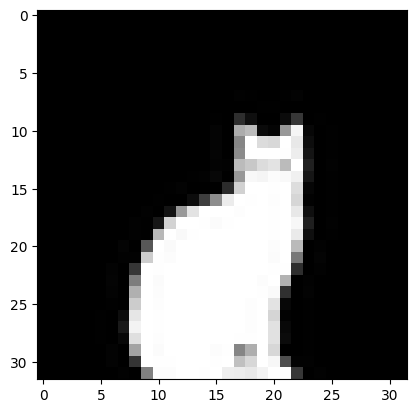

In [47]:
# dimensions of the image
size=32

#target image
image=get_Cat_image()

#normalized image
normalized_image=image_normalization(image,32,True)

#get target image pixel values for comparison with output image
img_arr=get_image_pixel_value(image,32)


In [48]:
# initialize qubits and classical registers for building the circuit
anc = QuantumRegister(1, "anc")
img = QuantumRegister(11, "img")
anc2 = QuantumRegister(1, "anc2")
c = ClassicalRegister(12)


In [49]:
# create circuit
qc = QuantumCircuit(anc, img, anc2, c)

# apply hadamard gates
for i in range(1, len(img)):
    qc.h(img[i])

# 
for i in range(len(normalized_image)):
        if normalized_image[i] != 0:
                #call a function before declarated
                c10mary(qc, 2 * normalized_image[i], format(i, '010b'), img[0], anc2[0], [img[j] for j in range(1,len(img))])


In [50]:
#rotate the image 180 deg
# qed.quantum_rotate_image(qc)

#Edge Detection 
# qed.quantum_edge_detection()

qc.measure(img, c[1:12])
print(qc.depth())
numOfShots = 1000000


31020


755 269
Total image recovered 73.73046875


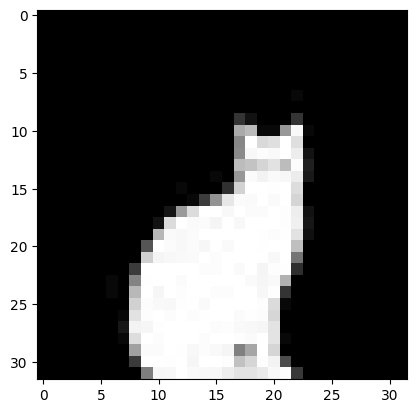

In [51]:
# To run without noise UNCOMMENT BELOW LINES
result = execute(qc, Aer.get_backend('qasm_simulator'), shots=numOfShots).result()

# Image retrieval from quantum state to pixels

genimg = np.array([])

#### decode
for i in range(len(normalized_image)):
        try:
                genimg = np.append(genimg,[np.sqrt(result.get_counts(qc)[format(i, '010b')+'10']/numOfShots)])
        except KeyError:
                genimg = np.append(genimg,[0.0])



# inverse nomalization
genimg *= size * 255.0
# genimg = np.sin(genimg)

same,notSame= get_count_of_pixel(img_arr,genimg)
print(same,notSame)
percentage= (same/1024)*100
print ("Total image recovered "+ str(percentage))

# convert type
genimg = genimg.astype('int')
genimg = genimg.reshape((size,size))
plt.imshow(genimg, cmap='gray', vmin=0, vmax=255)
plt.savefig('Result'+'.png')
plt.show()